<a href="https://colab.research.google.com/github/HugoKD/RouteNet-GNN/blob/main/PFE_MSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.nn import GCNConv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import io
from google.colab import files
path_to_image = '/content/drive/MyDrive/Colab Notebooks/FichiersPourColab/Screenshot from 2024-11-16 23-18-22.png'
path_to_image2 = '/content/drive/MyDrive/Colab Notebooks/FichiersPourColab/Screenshot from 2024-11-17 17-28-09.png'


In [ ]:
img = Image.open(path_to_image)
img2 = Image.open(path_to_image2)

# Training GCN

De base, nous avons des informations au niveau des edges (arêtes) ou des nodes (nœuds) du graphe. Pour exploiter ces données, on commence par utiliser un MLP (Multilayer Perceptron) pour effectuer un embedding, c'est-à-dire transformer ces informations en des vecteurs de caractéristiques plus riches.

Problème : Parfois, on souhaite obtenir des informations sur les edges à partir des embeddings des nodes, ou inversement. Dans ces cas, on peut utiliser des techniques de pooling pour transférer l'information d'un type d'entité à l'autre :

* Node-to-Edge Pooling : Si on dispose seulement d'informations sur les nodes et qu'on veut prédire des caractéristiques au niveau des edges, on agrège les embeddings des nœuds voisins pour créer un embedding pour chaque arête. Par exemple, on peut concaténer, sommer ou faire une moyenne des embeddings des deux nœuds connectés par une arête.
* Edge-to-Node Pooling : À l'inverse, si les informations sont disponibles uniquement sur les edges et que l'on souhaite les utiliser pour prédire des propriétés des nodes, on collecte les embeddings des arêtes incidentes à chaque nœud et on les agrège (somme, moyenne, maximum, etc.) pour générer un embedding pour le nœud.

Une fois que nous avons ces embeddings homogènes pour les nodes et/ou les edges, nous pouvons les utiliser pour former un graphe "final" que l'on peut exploiter dans une tâche de prédiction globale, comme la classification d'un graphe entier (par exemple, prédire si une molécule est toxique ou non).
Limitation de cette approche

Cependant, cette méthode ne prend pas en compte la structure du graphe ni la connectivité des nœuds. Cela signifie que chaque nœud ou arête est traité individuellement sans considération pour son voisinage direct ou la topologie globale du graphe.
Solution : Message Passing

Pour exploiter pleinement les relations et la structure du graphe, on utilise la technique de **message passing** dans les GNNs (Graph Neural Networks). Le message passing consiste à : <br>


* For each node in the graph, gather all the neighboring node embeddings (or messages)
* Aggregate all messages via an aggregate function (like sum).
* All pooled messages are passed through an update function, usually a learned neural network.


En empilant -ou stackant- plusieurs couches de message passing dans un Graph Neural Network (GNN), chaque nœud peut progressivement intégrer de l'information provenant d'une zone de plus en plus large du graphe. <br>

Dans un GCN, la matrice de poids W(l) à chaque couche est apprise automatiquement à partir des données lors de l'entraînement via un processus d'optimisation, comme dans les réseaux de neurones traditionnels. Cette étape d'apprentissage constitue le cœur de l'intelligence artificielle dans les GCN :

* Les poids W(l) sont ajustés à chaque itération pour minimiser une fonction de perte (L), qui représente l'erreur entre les prédictions du modèle et les valeurs réelles (par exemple, les labels des nœuds).
* L'intelligence dans les GCN repose également sur la propagation de messages entre les nœuds, où chaque nœud agrège les informations de ses voisins. Cette agrégation est guidée par les poids appris W(l)W(l), qui déterminent comment les features de chaque nœud et de ses voisins sont combinées.

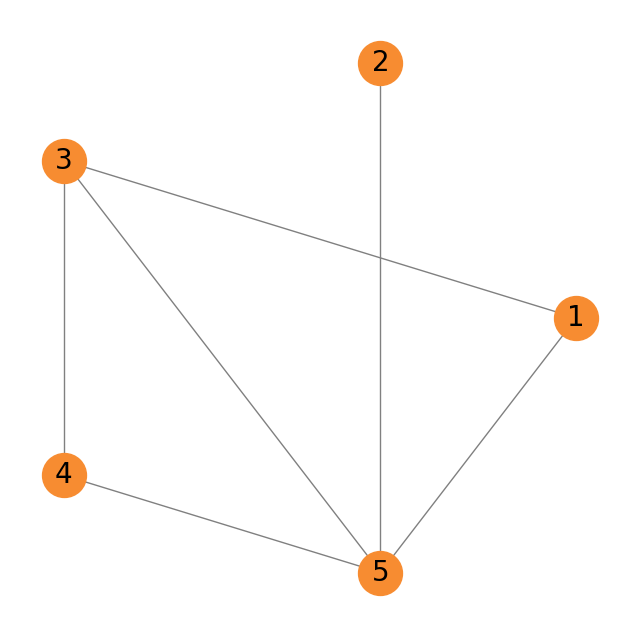

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Adj = np.array(
    [[0, 0, 1, 0, 1],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 1, 1],
     [0, 0, 1, 0, 1],
     [1, 1, 0, 0, 0]]
)
g = nx.from_numpy_array(Adj)
pos = nx.circular_layout(g)

fig, ax = plt.subplots(figsize=(8,8))
nx.draw(g, pos, with_labels=True,
    labels={i: i+1 for i in range(g.number_of_nodes())}, node_color='#f78c31',
    ax=ax, edge_color='gray', node_size=1000, font_size=20, font_family='DejaVu Sans')

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


# Features des nœuds (3 nœuds, 3 features)
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]], dtype=torch.float)

# Indices des arêtes (représentation des connexions)
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)

# Labels des nœuds (ex : 2 classes, 0 et 1)
y = torch.tensor([0, 1, 0], dtype=torch.long)

num_features = x.size(1)  # Nombre de features par nœud
hidden_dim = 4            # Taille de la couche cachée, donnée par la taille de la matrice des poids
out_dim = 2               # Nombre de classes à prédire (2 classes : 0 et 1)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)  # Première couche GCN
        self.conv2 = GCNConv(hidden_dim, out_dim)       # Deuxième couche GCN

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)   # Fonction d'activation ReLU
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_features=num_features, hidden_dim=hidden_dim, out_dim=out_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


n_epochs = 5000

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    out = model(x, edge_index)

    loss = loss_fn(out, y)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch + 1}/{n_epochs}, Perte : {loss.item():.4f}")


model.eval()
print(out)
_, predictions = torch.max(out, dim=1)
print("\nPrédictions finales : ", predictions.numpy())
print("\nLabels réels : ", y.numpy())

Époque 10/5000, Perte : 1.8017
Époque 20/5000, Perte : 0.8152
Époque 30/5000, Perte : 0.6378
Époque 40/5000, Perte : 0.6376
Époque 50/5000, Perte : 0.6370
Époque 60/5000, Perte : 0.6367
Époque 70/5000, Perte : 0.6366
Époque 80/5000, Perte : 0.6366
Époque 90/5000, Perte : 0.6366
Époque 100/5000, Perte : 0.6365
Époque 110/5000, Perte : 0.6365
Époque 120/5000, Perte : 0.6365
Époque 130/5000, Perte : 0.6365
Époque 140/5000, Perte : 0.6365
Époque 150/5000, Perte : 0.6365
Époque 160/5000, Perte : 0.6365
Époque 170/5000, Perte : 0.6365
Époque 180/5000, Perte : 0.6365
Époque 190/5000, Perte : 0.6365
Époque 200/5000, Perte : 0.6365
Époque 210/5000, Perte : 0.6365
Époque 220/5000, Perte : 0.6365
Époque 230/5000, Perte : 0.6365
Époque 240/5000, Perte : 0.6365
Époque 250/5000, Perte : 0.6365
Époque 260/5000, Perte : 0.6365
Époque 270/5000, Perte : 0.6365
Époque 280/5000, Perte : 0.6365
Époque 290/5000, Perte : 0.6365
Époque 300/5000, Perte : 0.6365
Époque 310/5000, Perte : 0.6365
Époque 320/5000, 

#Vanilla MPNN

The Vanilla MPNN uses explicit functions for each step:

* Message Function: mu→v=M(hu,hv,eu,v)mu→v​=M(hu​,hv​,eu,v​).
* Aggregation: mv=∑u∈N(v)mu→vmv​=∑u∈N(v)​mu→v​.
* Update Function: hv(t+1)=U(hv(t),mv(t))hv(t+1)​=U(hv(t)​,mv(t)​).

# RouteNET

Implement the same concepts as Vanilla MPNN

Here embeddings have the purpose to describe network metrics (such as jitter, packet loss etc.). So as inputs, we get two info : paths features and nodes features (with the the routing description R)

*Goal :* To predict path-level performances

Especially, it relies on two assumptions :

1) The state of a path depends on the state of all the links
that lie on the path. <br>

2) The state of a link depends on the state of all the paths
that traverse the link.

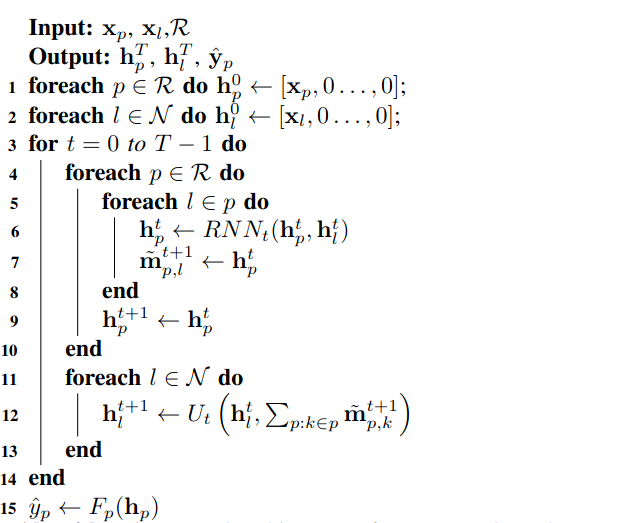

In [ ]:
img

What's interesting here is how they use RNN to capture sequential and contextual dependencies over iterative message-passing steps or along structured paths in a graph. <br>
Because, order in which packet goes through path, we use RNN to give the sens of memory. <br>
D'abord on update les paths, en itérant sur les links qui le composent. Puis, on calcule l'embedding de chaque lien, pour TOUS les liens du réseau. <br>
Alors on a bien traduis le point 1) et 2) du paragraphe précédent.

Le rôle de l’intelligence artificielle ici est d’apprendre les paramètres optimaux des fonctions RNN_t,U_t,F_p pour effectuer la prédiction d'une metrique spécifique pour les chemins p en fonction des caracteritsiques des chemins et des liens (e.g., prédire la latence, la perte de paquets, etc.). <br>

* RNN_t Modélise comment un chemin 𝑝 intègre les informations des liens 𝑙 qu'il traverse.
* U_t Modélise comment un lien 𝑙 l intègre les informations des chemins 𝑝 p qui le traversent.
* F_p Génère la sortie finale y^p, comme une latence prédite, à partir de l'embedding final h^T_p

Ces fonctions sont paramétrées (par exemple, via des MLPs ou des réseaux de neurones), et l'objectif est d'apprendre les paramètres de ces fonctions à partir des données.


Exemple de fonction de perte pour prédire la latence :  𝐿 = (1 ∣ 𝑃 ∣) ∑ 𝑝 ∈ 𝑃 ( y^_p − 𝑦_𝑝 )²

F_p can be such that : **y^_p = [μ_i,σ_i] = [Delay, Jitter]**.
The model assumes the true delay distribution for the ièth path follows : W_i = N(μ_i_true,σ_i²_true)

**So** the loss fn is the log likelihood of the data we get (from a certain graph dataset) having our parameters we've predict. The goal so is to find the best delay and kitter value such that we maximise our likelihood.



# RouteNet-Fermi

The main reason traditional Message Passing Neural Networks (MPNNs) fail in scenarios with varying routing configurations is that their architecture relies heavily on the network topology without explicitly considering the paths traversed by different traffic flows. In simpler terms, MPNNs focus on how nodes (e.g., routers or switches) are connected (links), but they do not take into account which specific paths different traffic flows use to traverse the network. And we know performance of a flow is not only determined by its own characteristics but also by the paths it traverses and the links it shares with other flows. For isntance, in real-world networks, multiple flows can traverse the same path or share specific links. This means that the state of the network links (like congestion, packet loss, and delay) is heavily influenced by all flows using those links.

This is a critical flaw because traffic behavior and network performance are not determined solely by the physical topology but by how data packets are routed across paths in the network.

Indeed :For accurate network performance prediction, understanding the interaction between flows and how they share or compete for link capacity is crucial. However, vanilla MPNNs do not account for the routing configuration (which paths flows take), making it hard for them to learn how changes in routing affect network performance.

There is a circular dependency between the state of the links and the state of the flows.
* The state of a flow (e.g., its delay, packet loss) depends on the state of the links it traverses (e.g., congestion level, available bandwidth).
* Conversely, the state of a link (e.g., its load or congestion) depends on the aggregate state of all flows passing through it.

To overcome this limitation, RouteNet-Fermi (RouteNet-F) introduces a path-aware GNN architecture:

Flow: F = { 𝑓𝑖 : 𝑖 ∈ (1, ..., 𝑛 𝑓 )} where 𝑓𝑖 = {(𝑞¹_i, 𝑙¹_i), ..., (𝑞^M_i , 𝑙^M_i )}, M being the length of the path (or flow)
Queues (Q): A set of queues Q = {𝑞 𝑗 : 𝑗 ∈ (1, ..., 𝑛𝑞 )},  where each queue is an output buffer in a network device.
Links (L): A set of physical links L = {𝑙𝑘 : 𝑘 ∈ (1, ..., 𝑛𝑙 )} that connect different network devices.


AND, each component can be dependant of others :  <br>

**Principle 1: State of Flows:** h 𝑓𝑖 = 𝐺 𝑓 (h𝑞𝑖,1 , h𝑙𝑖,1 , ..., h𝑞𝑖,𝑀 , h𝑙𝑖,𝑀 ) , ⇔ IE l'état de chaque flow dépend de le tous les composants qu'il traverse, soit les queues à chaque buffer + l'état des liens <br>

**Principle 2: State of Queues:** h𝑞𝑗 = 𝐺𝑞 (h 𝑓1 , ..., h 𝑓𝐼 ), 𝑓𝑖 ∈ 𝑄 𝑓 (𝑞 𝑗 ) <br>

**Principle 3: State of Links:** h𝑙𝑘 = 𝐺𝑙 (h𝑞1 , ..., h𝑞𝐽 ), 𝑞 𝑗 ∈ 𝐿𝑞 (𝑙 𝑗 )


To do so, it implements a three-stage message passing algorithm that combines the states of flows F , queues Q, and links L, and updates them iteratively. Finally, it combines these states to estimate flow-level delays, jitters,
and packet loss

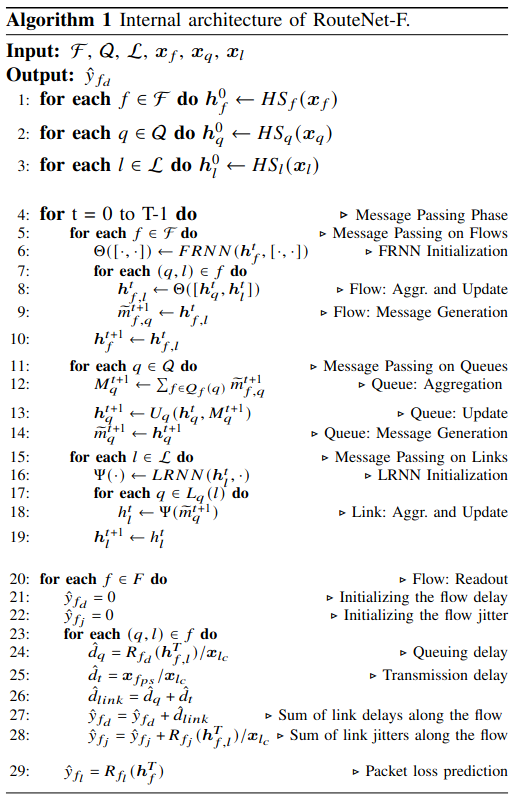

In [ ]:
img2

Ainsi à la fin du mesage passing, on a un etat final pour chaque q, qui prend en compte les effets de chaque flow qui traverse ce buffer, ie pour chaque message m_f_q. Sauf que m_f_q dépend lui même de tous les liens et de tous les q qui composent f !

Après la phae de message passing, on a une info encodée pour chaque lien et queue et flow du réseau. On utilise chacun pour la phase de ReadOut. <br>

Ainsi, the delay for a flow f is computed by aggregating the delay contributions from each queue-link pair (q,l) that the flow traverses. /xlc​​: The capacity of the link l.

BUT, here the model will struggle to scale up from tiny network (often use with simulation), allowing model to infer well on unsee real network situation. For instance, if the model was trained on networks with link capacities up to 10 Gbps, it may not generalize well to 100 Gbps links without special mechanisms + the effect on link capabilities isn't linear.

So we introduce :
* 𝑥𝑙𝑜𝑎𝑑 = 1/𝑥𝑙𝑐∑︁ 𝑓 ∈ 𝐿 𝑓 (𝑙𝑗 )𝜆_𝑓 where : The average traffic volume of a flow f and the link load represents the ratio between the aggregated traffic of flows traversing the link and the link's capacity.This ratio captures how "busy" a link is, independent of its raw capacity.This allows RouteNet-Fermi to make predictions based on relative congestion levels, which generalize better across varying capacity scales.

* RouteNet-F infers delays indirectly from the mean queue occupancy on forwarding
devices

RQ : Le Type of Service (ToS) est un champ dans l'en-tête d'un paquet IP qui permet de spécifier la priorité ou la classe de service d'un paquet

Le zip donné en entrée est composé de 3 fichiers: <br>

* Graph topology: node/edge and their characteristics (bandwiths,levelsToS,Scheduling policy (FIFO,SP,DRR), buffer size. On le génère avec la lib networkx
par exemple :
      G = nx.complete_graph(10)

      # Set the number of ToS that the input traffic of the network can use. If it is not defined, the simulator sets it to 1.
      G.graph["levelsToS"] = 3

      # Assign bandwidth to each edge of the graph. Its value is considered in bps.
      for (n0,n1) in G.edges():
          G[n0][n1]["bandwidth"] = 100000

      for node in G:<br>
        G.nodes[node]["bufferSizes"] = 32000
        G.nodes[node]["schedulingPolicy"] = "SP"
        G.nodes[node]["tosToQoSqueue"] = "0;1,2"
        G.nodes[node]["schedulingWeights"] = "45, 30, 25"


* Un fichier qui gère le Routing : a text file, where each line represents a path through the network as a sequence of nodes. Either destination-based and source-destination-based routing.
* Traffic Matrix : qui gère les flux. Chaque ligne de ce fichier représente un flux, présetnant différentes caractéristiques toutes séparées par des virgules.
  * source and destination node for a given flow
  * avg_bandwith (avg_bw) for this flow.
  * time_distribution :  indicates how often packets should be generated over time.
    * Poisson(time_distribution=1)
    * BR(time_distribution=1): constant rate
    * ON-OFF(time_distribution=2)
    * EXT_PYTHON(time_distribution=3)
  * pkt_dis : notes the distribution type used to generate the packets.
    * Generic(size_distribution=0):
    * EXT_PYTHON(size_distribution=1):
  * tos : ToS assigned to the packets generated for this flow


Implémentation :

* If we want to train the model -> main.py



## Datanet API :
* Iterator :reading and processing a sample from the dataset
* Sample Instance : Creating a single instance, with the expected structure

**Repo fat tree :** A classic network topology. Elle est conçue pour être scalable et fournir une connectivité uniforme tout en maximisant la bande passante entre les nœuds.Un Fat Tree est basé sur le concept d’arbre, mais contrairement à un arbre classique, les liens entre les nœuds deviennent plus "larges" (plus de capacité ou plus de chemins parallèles) en montant dans la hiérarchie, d’où le terme "fat" (gros)


- Le Constant Bitrate (CBR) traffic désigne un modèle de trafic réseau où les données sont transmises à un débit fixe, c’est-à-dire avec un intervalle régulier entre les paquets. Ce type de trafic est courant dans des applications qui nécessitent une qualité de service constante, comme la téléphonie sur IP (VoIP), la vidéoconférence ou le streaming vidéo.
- Le traffic autocorrelated, les schémas de transmission présentent une corrélation temporelle entre les paquets. Cela signifie que la quantité et la fréquence des données transmises à un moment donné sont influencées par celles des moments précédents.
- Les périodes "on" et "off" peuvent être déterminées aléatoirement ou suivre une distribution spécifique (comme exponentielle ou Poisson).
Ce modèle est courant pour des applications sporadiques comme la messagerie instantanée ou les flux intermittents.
- Le trafic modulated est caractérisé par des variations régulières ou périodiques dans le débit, souvent modulées par une fonction ou une fréquence donnée. Simule des scénarios où les flux varient en intensité selon un schéma déterminé (comme un débit qui fluctue en fonction de l'heure ou d'un cycle).
Utilisé pour modéliser des applications telles que les vidéos ou les capteurs IoT avec des modèles de communication cycliques.
- All-Multiplexed Traffic: Le trafic all-multiplexed combine plusieurs flux de trafic individuels en un flux unique, simulant une situation où plusieurs utilisateurs ou applications partagent les mêmes ressources réseau.

**Repo :**
- Fat Tree, realk traffic, all mixed: This model has been trained to predict the delay.
- scalavbility ; This model has been trained to predict two performance metrics (Delay and Jitter). : Ce répertoire est dédié à l'évaluation et à l'entraînement de modèles conçus pour être scalables, c'est-à-dire capables de généraliser à des topologies réseau de plus grande échelle ou avec des configurations variées.
- Scheduling : this model has been trained to predict three performance metrics (Delay, Jitter and Losses). : Ce répertoire contient des modèles conçus pour prédire les performances réseau dans des scénarios avec des politiques de scheduling spécifiques. (Le scheduling détermine l’ordre dans lequel les paquets sont transmis ou traités, influençant directement les performances.)
- Testbed :Ce répertoire représente un environnement de test basé sur des données réelles ou synthétiques, utilisé pour valider la performance des modèles.
- Traffic model : this model has been trained to predict three performance metrics (Delay, Jitter and Losses). : Ce répertoire regroupe des modèles entraînés sur des scénarios variés en fonction des modèles de trafic (par exemple, constant bitrate, modulated, all-multiplexed).


#TODO :
- On defint la loss, voir quel sont les target quel est l'objectif